In [1]:
import pandas as pd
import numpy as np

### cleaning ALP survey data

In [2]:
ms480_df = pd.read_stata('alp_data/ms480_weighted.dta', convert_categoricals=False)
ms436_df = pd.read_stata('alp_data/ms436_weighted_stata.dta', convert_categoricals=False)

In [3]:
ms480 = ms480_df[['prim_key', 'weight', 
                  'gender', 'c2'
                 ]].set_index('prim_key')
ms436 = ms436_df[['prim_key', 'weight', 
                  'gender', 'q3_occupation', 
                  'q3_occupationcode'
                 ]].set_index('prim_key')

In [4]:
# Inner join the two dataframes on prim_key
df = ms480.join(ms436, how='inner', lsuffix='_ms480', rsuffix='_ms436')
df = df.rename(columns={'c2': 'stem_job', 'q3_occupation': 'occ_text', 'q3_occupationcode': 'occ_code'})
df

,weight_ms480,gender_ms480,stem_job,weight_ms436,gender_ms436,occ_text,occ_code
prim_key,,,,,,,
10017494:1,1.026857,2,2.0,1.362734,2,law,23-1011 Lawyers
10018010:1,0.386444,2,2.0,0.462753,2,election clerk,"43-9061 Office Clerks, General"
10027497:1,0.484295,2,2.0,0.832929,2,phy,29-1071 Physician Assistants
10027500:1,1.395137,1,2.0,6.611482,1,,
10027508:1,0.724392,2,2.0,0.721815,2,Substitute,
...,...,...,...,...,...,...,...
9117483:1,0.542048,2,2.0,0.521128,2,retai,41-1011 First-Line Supervisors of Retail Sales...
9117484:1,0.480405,2,2.0,0.997764,2,,
9117485:1,0.398254,2,2.0,0.276730,2,wai,35-3031 Waiters and Waitresses


In [5]:
all((df['gender_ms480'] == df['gender_ms436']).values)

True

In [6]:
df = df.drop(['gender_ms436'], axis=1).rename(columns={'gender_ms480': 'gender'})
df

,weight_ms480,gender,stem_job,weight_ms436,occ_text,occ_code
prim_key,,,,,,
10017494:1,1.026857,2,2.0,1.362734,law,23-1011 Lawyers
10018010:1,0.386444,2,2.0,0.462753,election clerk,"43-9061 Office Clerks, General"
10027497:1,0.484295,2,2.0,0.832929,phy,29-1071 Physician Assistants
10027500:1,1.395137,1,2.0,6.611482,,
10027508:1,0.724392,2,2.0,0.721815,Substitute,
...,...,...,...,...,...,...
9117483:1,0.542048,2,2.0,0.521128,retai,41-1011 First-Line Supervisors of Retail Sales...
9117484:1,0.480405,2,2.0,0.997764,,
9117485:1,0.398254,2,2.0,0.276730,wai,35-3031 Waiters and Waitresses


In [7]:
df['occ_cat'] = df['occ_code'].map(lambda x: ' '.join(x.split()[1:]))
df['occ_code'] = df['occ_code'].map(lambda x: ' '.join(x.split()[:1]))
df

,weight_ms480,gender,stem_job,weight_ms436,occ_text,occ_code,occ_cat
prim_key,,,,,,,
10017494:1,1.026857,2,2.0,1.362734,law,23-1011,Lawyers
10018010:1,0.386444,2,2.0,0.462753,election clerk,43-9061,"Office Clerks, General"
10027497:1,0.484295,2,2.0,0.832929,phy,29-1071,Physician Assistants
10027500:1,1.395137,1,2.0,6.611482,,,
10027508:1,0.724392,2,2.0,0.721815,Substitute,,
...,...,...,...,...,...,...,...
9117483:1,0.542048,2,2.0,0.521128,retai,41-1011,First-Line Supervisors of Retail Sales Workers
9117484:1,0.480405,2,2.0,0.997764,,,
9117485:1,0.398254,2,2.0,0.276730,wai,35-3031,Waiters and Waitresses


In [8]:
df = df.replace('', np.nan).dropna()
df['stem_job'] = df['stem_job'].replace(2.0, 0).astype('int')

In [9]:
alp_df = df

### cleaning O*Net data

In [10]:
def use_onet_data(table_list, alp_df): 
    dfs = {}
    for table in table_list: 
        dfs[table] = pd.read_csv(f'onet_data/db_24_2_text/{table}', delimiter='\t')
        dfs[table] = dfs[table][['O*NET-SOC Code', 'Element ID', 'Data Value']]
        dfs[table].loc[:, 'SOC Code'] = dfs[table]['O*NET-SOC Code'].map(lambda x: x.split('.')[0]).values
        dfs[table] = dfs[table].groupby(['SOC Code', 'Element ID']).mean()
        dfs[table] = dfs[table].reset_index().pivot(index='SOC Code', columns='Element ID', values='Data Value')
    merge_table = alp_df
    for table in table_list: 
        merge_table = merge_table.merge(dfs[table], on='SOC Code', how='left')
    return merge_table

In [11]:
alp_df = df
alp_df = alp_df.rename(columns={'occ_code': 'SOC Code'})
alp_df.head()

,weight_ms480,gender,stem_job,weight_ms436,occ_text,SOC Code,occ_cat
prim_key,,,,,,,
10017494:1,1.026857,2,0,1.362734,law,23-1011,Lawyers
10018010:1,0.386444,2,0,0.462753,election clerk,43-9061,"Office Clerks, General"
10027497:1,0.484295,2,0,0.832929,phy,29-1071,Physician Assistants
10027509:1,0.435700,2,0,0.525075,adm,11-3011,Administrative Services Managers
10027514:1,1.179199,2,0,1.354282,sale,41-9022,Real Estate Sales Agents


In [12]:
weghts = alp_df['weight_ms480'].values

In [13]:
alp_df = alp_df[['stem_job', 'SOC Code']]

#### Merge dataframes

In [14]:
merge_df = use_onet_data(['Knowledge.txt', 'Skills.txt', 'Work Activities.txt'], alp_df)

In [15]:
merge_df

,stem_job,SOC Code,2.C.1.a,2.C.1.b,2.C.1.c,2.C.1.d,2.C.1.e,2.C.1.f,2.C.10,2.C.2.a,...,4.A.4.a.8,4.A.4.b.1,4.A.4.b.2,4.A.4.b.3,4.A.4.b.4,4.A.4.b.5,4.A.4.b.6,4.A.4.c.1,4.A.4.c.2,4.A.4.c.3
0,0,23-1011,3.9550,2.5200,3.1200,1.8350,4.5300,3.8100,1.635,1.4900,...,4.030,3.5450,2.9000,2.930,2.880,2.820,4.8200,3.665,2.160,2.6700
1,0,43-9061,2.7600,4.6550,2.2550,1.8400,3.5800,2.2100,1.430,1.5600,...,2.905,2.4550,1.9400,2.230,1.705,2.105,1.4050,3.425,1.640,1.9150
2,0,29-1071,2.2675,2.5325,1.5225,1.1725,4.3875,2.0875,1.660,1.3525,...,3.895,3.3175,3.3225,3.655,3.005,3.265,3.5475,2.800,1.920,2.3375
3,0,11-3011,4.4000,4.5400,3.0300,1.9750,4.8050,3.7350,1.675,2.9550,...,3.075,4.3250,3.6200,3.510,4.335,4.005,3.6050,4.125,3.505,4.0000
4,0,41-9022,4.0400,4.1350,3.3850,5.1350,5.3000,2.6750,2.705,1.9200,...,4.455,3.8000,3.6200,3.365,3.225,3.585,4.0650,3.815,2.640,2.9500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,0,25-2052,3.2050,3.9650,0.7100,0.8250,3.8350,1.9400,1.300,0.7550,...,3.455,3.5600,3.3400,4.365,3.495,4.250,3.0100,3.830,2.485,1.9900
1420,0,43-4171,2.4800,4.4400,1.6200,1.3800,4.1150,2.1250,1.155,1.2450,...,4.630,2.1850,2.6650,2.720,1.910,2.745,1.3950,4.400,1.020,1.4850
1421,0,39-2021,2.4950,3.0750,1.5400,2.0750,4.2600,2.1600,1.510,1.7400,...,3.480,2.7850,2.4000,2.960,2.035,2.555,2.4450,2.480,1.435,2.4600
1422,0,41-1011,4.3700,3.5700,3.4300,3.7800,5.2250,3.1850,1.080,2.7450,...,4.340,3.9450,3.6150,4.185,4.005,4.195,2.9500,2.995,3.335,2.7800


In [280]:
merge_df = merge_df.dropna()
merge_df

,stem_job,SOC Code,2.C.1.a,2.C.1.b,2.C.1.c,2.C.1.d,2.C.1.e,2.C.1.f,2.C.10,2.C.2.a,...,4.A.4.a.8,4.A.4.b.1,4.A.4.b.2,4.A.4.b.3,4.A.4.b.4,4.A.4.b.5,4.A.4.b.6,4.A.4.c.1,4.A.4.c.2,4.A.4.c.3
0,0,23-1011,3.9550,2.5200,3.1200,1.8350,4.5300,3.8100,1.635,1.4900,...,4.030,3.5450,2.9000,2.930,2.880,2.820,4.8200,3.665,2.160,2.6700
1,0,43-9061,2.7600,4.6550,2.2550,1.8400,3.5800,2.2100,1.430,1.5600,...,2.905,2.4550,1.9400,2.230,1.705,2.105,1.4050,3.425,1.640,1.9150
2,0,29-1071,2.2675,2.5325,1.5225,1.1725,4.3875,2.0875,1.660,1.3525,...,3.895,3.3175,3.3225,3.655,3.005,3.265,3.5475,2.800,1.920,2.3375
3,0,11-3011,4.4000,4.5400,3.0300,1.9750,4.8050,3.7350,1.675,2.9550,...,3.075,4.3250,3.6200,3.510,4.335,4.005,3.6050,4.125,3.505,4.0000
4,0,41-9022,4.0400,4.1350,3.3850,5.1350,5.3000,2.6750,2.705,1.9200,...,4.455,3.8000,3.6200,3.365,3.225,3.585,4.0650,3.815,2.640,2.9500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1419,0,25-2052,3.2050,3.9650,0.7100,0.8250,3.8350,1.9400,1.300,0.7550,...,3.455,3.5600,3.3400,4.365,3.495,4.250,3.0100,3.830,2.485,1.9900
1420,0,43-4171,2.4800,4.4400,1.6200,1.3800,4.1150,2.1250,1.155,1.2450,...,4.630,2.1850,2.6650,2.720,1.910,2.745,1.3950,4.400,1.020,1.4850
1421,0,39-2021,2.4950,3.0750,1.5400,2.0750,4.2600,2.1600,1.510,1.7400,...,3.480,2.7850,2.4000,2.960,2.035,2.555,2.4450,2.480,1.435,2.4600
1422,0,41-1011,4.3700,3.5700,3.4300,3.7800,5.2250,3.1850,1.080,2.7450,...,4.340,3.9450,3.6150,4.185,4.005,4.195,2.9500,2.995,3.335,2.7800


### Classification

In [17]:
X = merge_df.drop(columns=['stem_job', 'SOC Code']).values
y = merge_df['stem_job'].values

In [18]:
X.shape, y.shape

((1279, 109), (1279,))

#### standardization: mean removal and variance scaling

In [19]:
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, RidgeCV, LinearRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, RFECV
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report, confusion_matrix  

import pickle

In [20]:
# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=25)

#### try models

In [40]:
# 1

In [75]:
# Construct pipeline 1: 0. standardization 1. feature_selection LassoCV 2. RandomForestClassifier

pipeline_stand_lasso_randforest = Pipeline([
  ('standardization', StandardScaler()), 
  ('feature_selection', SelectFromModel(LassoCV())), 
  ('classification', RandomForestClassifier())
])

In [76]:
# Hyperparameter tuning by grid searching with cross-validation 

# Set the parameters for grid searching
params_grid_pipeline_stand_lasso_randforest = {
    'classification__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'classification__max_features': ['auto', 'sqrt'], 
    'classification__max_depth': [int(x) for x in np.linspace(10, 100, 10)] + [None]
}

# GridSearchCV for pipeline1
pipeline_stand_lasso_randforest_cv = GridSearchCV(
    pipeline_stand_lasso_randforest, 
    params_grid_pipeline_stand_lasso_randforest, 
    cv=5, n_jobs=-1
)

In [77]:
pipeline_stand_lasso_randforest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardization',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LassoCV(alphas=None,
                                                                          copy_X=True,
                                                                          cv=None,
                                                                          eps=0.001,
                                                                          fit_intercept=True,
                                                                          max_iter=1000,
                                                                 

In [78]:
pipeline_stand_lasso_randforest_cv.score(X_train, y_train), pipeline_stand_lasso_randforest.score(X_test, y_test) # seems overfitting

(0.8670576735092864, 0.796875)

In [79]:
pipeline_stand_lasso_randforest_cv.best_params_

{'classification__max_depth': 30,
 'classification__max_features': 'auto',
 'classification__n_estimators': 500}

In [82]:
# Save to file in the current working directory
pkl_filename = "pipeline_stand_lasso_randforest"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipeline_stand_lasso_randforest_cv, file)

# # Load from file
# with open(pkl_filename, 'rb') as file:
#     pickle_model = pickle.load(file)
    
# # Calculate the accuracy score and predict target values
# score = pickle_model.score(X_test, y_test)
# print("Test score: {0:.2f} %".format(100 * score))
# y_predict = pickle_model.predict(X_test)

In [121]:
print(classification_report(y_test, pipeline_stand_lasso_randforest_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       196
           1       0.57      0.57      0.57        60

    accuracy                           0.80       256
   macro avg       0.72      0.72      0.72       256
weighted avg       0.80      0.80      0.80       256



In [ ]:
# 2

In [84]:
# Construct pipeline 2: 0. standardization 1. feature_selection RidgeCV 2. RandomForestClassifier

pipeline_stand_ridge_randforest = Pipeline([
  ('standardization', StandardScaler()), 
  ('feature_selection', SelectFromModel(RidgeCV())), 
  ('classification', RandomForestClassifier())
])

params_grid_pipeline_stand_ridge_randforest = {
    'classification__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'classification__max_features': ['auto', 'sqrt'], 
    'classification__max_depth': [int(x) for x in np.linspace(10, 100, 10)] + [None]
}

pipeline_stand_ridge_randforest_cv = GridSearchCV(
    pipeline_stand_ridge_randforest, 
    params_grid_pipeline_stand_ridge_randforest, 
    cv=5, n_jobs=-1
)

In [85]:
pipeline_stand_ridge_randforest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardization',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=RidgeCV(alphas=array([ 0.1,  1. , 10. ]),
                                                                          cv=None,
                                                                          fit_intercept=True,
                                                                          gcv_mode=None,
                                                                          normalize=False,
                                                                          scoring=None,
                                     

In [87]:
pipeline_stand_ridge_randforest_cv.score(X_train, y_train), pipeline_stand_ridge_randforest_cv.score(X_test, y_test)

(0.8670576735092864, 0.79296875)

In [88]:
pkl_filename = "pipeline_stand_ridge_randforest"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipeline_stand_ridge_randforest_cv, file)

In [120]:
print(classification_report(y_test, pipeline_stand_ridge_randforest_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       196
           1       0.56      0.57      0.56        60

    accuracy                           0.79       256
   macro avg       0.71      0.71      0.71       256
weighted avg       0.79      0.79      0.79       256



In [ ]:
# 3

In [95]:
# Construct pipeline 3: 0. standardization 1. feature_selection LogistsicRegressionCV 2. RandomForestClassifier

pipeline_stand_logit_randforest = Pipeline([
  ('standardization', StandardScaler()), 
  ('feature_selection', SelectFromModel(LogisticRegressionCV(max_iter=1000))), 
  ('classification', RandomForestClassifier())
])

params_grid_pipeline_stand_logit_randforest = {
#     'feature_selection__estimator__l1_ratio': np.linspace(0, 1, 6), 
    'classification__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'classification__max_features': ['auto', 'sqrt'], 
    'classification__max_depth': [int(x) for x in np.linspace(10, 100, 10)] + [None]
}

pipeline_stand_logit_randforest_cv = GridSearchCV(
    pipeline_stand_logit_randforest, 
    params_grid_pipeline_stand_logit_randforest, 
    cv=5, n_jobs=-1
)

In [96]:
pipeline_stand_logit_randforest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardization',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LogisticRegressionCV(Cs=10,
                                                                                       class_weight=None,
                                                                                       cv=None,
                                                                                       dual=False,
                                                                                       fit_intercept=True,
                                                                                       i

In [97]:
pipeline_stand_logit_randforest_cv.score(X_train, y_train), pipeline_stand_logit_randforest_cv.score(X_test, y_test)

(0.8670576735092864, 0.796875)

In [105]:
pkl_filename = "pipeline_stand_logit_randforest"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipeline_stand_logit_randforest_cv, file)

In [119]:
print(classification_report(y_test, pipeline_stand_logit_randforest_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       196
           1       0.57      0.57      0.57        60

    accuracy                           0.80       256
   macro avg       0.72      0.72      0.72       256
weighted avg       0.80      0.80      0.80       256



In [ ]:
# 4

In [98]:
# Construct pipeline 4: 0. standardization 1. RandomForestClassifier

pipeline_stand_randforest = Pipeline([
  ('standardization', StandardScaler()), 
  ('classification', RandomForestClassifier())
])

params_grid_pipeline_stand_randforest = {
    'classification__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
    'classification__max_features': ['auto', 'sqrt'], 
    'classification__max_depth': [int(x) for x in np.linspace(10, 100, 10)] + [None]
}

pipeline_stand_randforest_cv = GridSearchCV(
    pipeline_stand_randforest, 
    params_grid_pipeline_stand_randforest, 
    cv=5, n_jobs=-1
)

In [99]:
pipeline_stand_randforest_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardization',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('classification',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                          

In [100]:
pipeline_stand_randforest_cv.score(X_train, y_train), pipeline_stand_randforest_cv.score(X_test, y_test)

(0.8670576735092864, 0.80859375)

In [101]:
pipeline_stand_randforest_cv.best_params_

{'classification__max_depth': 60,
 'classification__max_features': 'auto',
 'classification__n_estimators': 200}

In [106]:
pkl_filename = "pipeline_stand_randforest"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pipeline_stand_randforest_cv, file)

In [118]:
print(classification_report(y_test, pipeline_stand_randforest_cv.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       196
           1       0.58      0.63      0.61        60

    accuracy                           0.81       256
   macro avg       0.73      0.75      0.74       256
weighted avg       0.81      0.81      0.81       256



In [ ]:
# 5

In [54]:
# Construct pipeline 5: 0. standardization 1. LogisticRegressionCV

pipeline_stand_logit = Pipeline([
  ('standardization', StandardScaler()), 
  ('classification', LogisticRegressionCV(n_jobs=-1))
])

In [55]:
pipeline_stand_logit.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardization',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classification',
                 LogisticRegressionCV(Cs=10, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1_ratios=None,
                                      max_iter=100, multi_class='auto',
                                      n_jobs=-1, penalty='l2',
                                      random_state=None, refit=True,
                                      scoring=None, solver='lbfgs', tol=0.0001,
                                      verbose=0))],
         verbose=False)

In [56]:
pipeline_stand_logit.score(X_train, y_train), pipeline_stand_logit.score(X_test, y_test)

(0.8211143695014663, 0.84375)

In [57]:
print(classification_report(y_test, pipeline_stand_logit.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       196
           1       0.75      0.50      0.60        60

    accuracy                           0.84       256
   macro avg       0.81      0.72      0.75       256
weighted avg       0.84      0.84      0.83       256



In [129]:
# 6

In [295]:
# Construct pipeline 3: 0. standardization 1. feature_selection RFECV+SVC 2. LogisticRegressionCV

pipeline_stand_svc_logit = Pipeline([
  ('standardization', StandardScaler()), 
  ('feature_selection', RFECV(SVC(kernel='linear'), min_features_to_select=30, n_jobs=-1)), 
  ('classification', LogisticRegressionCV(Cs=20, n_jobs=-1))
])


In [296]:
pipeline_stand_svc_logit.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardization',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('feature_selection',
                 RFECV(cv=None,
                       estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma='scale', kernel='linear',
                                     max_iter=-1, probability=False,
                                     random_state=None, shrinking=True,...
                       min_features_to_select=30, n_jobs=-1, scoring=None,
                       step=1, verbose=0)),
                ('classification',
                 LogisticRegressionCV(Cs=20, class_weight=None, cv=None,
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1.0, l1

In [297]:
pipeline_stand_svc_logit.score(X_train, y_train), pipeline_stand_svc_logit.score(X_test, y_test)

(0.8406647116324536, 0.84375)

In [299]:
print(classification_report(y_test, pipeline_stand_svc_logit.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       196
           1       0.72      0.55      0.62        60

    accuracy                           0.84       256
   macro avg       0.79      0.74      0.76       256
weighted avg       0.84      0.84      0.84       256



<IPython.core.display.Javascript object>


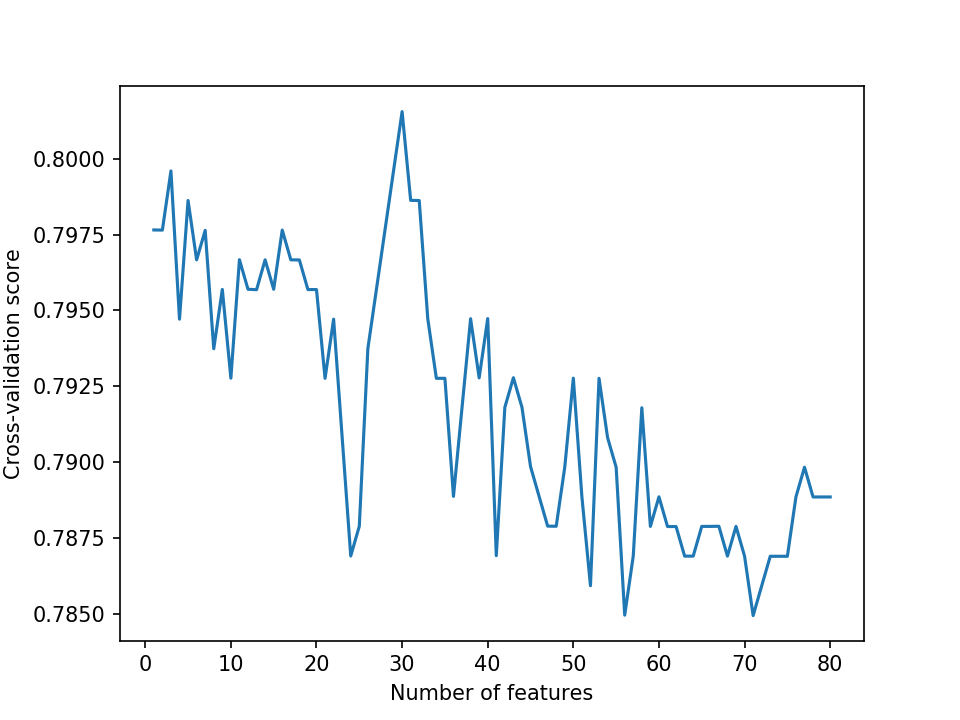

Text(0, 0.5, 'Cross-validation score')

In [326]:
plt.plot(range(1, len(pipeline_stand_svc_logit['feature_selection'].grid_scores_) + 1), pipeline_stand_svc_logit['feature_selection'].grid_scores_)
plt.xlabel('Number of features')
plt.ylabel('Cross-validation score')
# plt.title('Cross-validation scores of Recursive Feature Elimination \nwith Linear Support Vector Classifier')

In [ ]:
# 7

In [289]:
# # Construct pipeline 3: 0. standardization 1. feature_selection RFECV+SVC 2. LogisticRegressionCV

# pipeline_stand_svc_randforest = Pipeline([
#   ('standardization', StandardScaler()), 
#   ('feature_selection', RFECV(SVC(kernel='linear'), min_features_to_select=30, n_jobs=-1)), 
#   ('classification', RandomForestClassifier())
# ])

# param s_grid_pipeline_stand_svc_randforest = {
# #     'feature_selection__estimator__C': [10.0 ** order for order in np.arange(-2, 3, 1)], 
#     'classification__n_estimators': [int(x) for x in np.linspace(100, 1000, 10)],
#     'classification__max_features': ['auto', 'sqrt'], 
#     'classification__max_depth': [int(x) for x in np.linspace(10, 100, 10)] + [None]
# }

# pipeline_stand_svc_randforest_cv = GridSearchCV(
#     pipeline_stand_svc_randforest, 
#     params_grid_pipeline_stand_svc_randforest, 
#     cv=5, n_jobs=-1
# )

In [ ]:
# pipeline_stand_svc_randforest_cv.fit(X_train, y_train)

### Get full onet data for predicting STEM on all SOC occupations

In [246]:
def use_full_onet_data(table_list): 
    dfs = {}
    for table in table_list: 
        dfs[table] = pd.read_csv(f'onet_data/db_24_2_text/{table}', delimiter='\t')
        dfs[table] = dfs[table][['O*NET-SOC Code', 'Element ID', 'Data Value']]
        dfs[table].loc[:, 'SOC Code'] = dfs[table]['O*NET-SOC Code'].map(lambda x: x.split('.')[0]).values
        dfs[table] = dfs[table].groupby(['SOC Code', 'Element ID']).mean()
        dfs[table] = dfs[table].reset_index().pivot(index='SOC Code', columns='Element ID', values='Data Value')
    for ind, table in enumerate(table_list): 
        if ind == 0: 
            merge_table = dfs[table]
        else: 
            merge_table = merge_table.merge(dfs[table], on='SOC Code', how='inner')
    return merge_table

In [247]:
full_onet = use_full_onet_data(['Knowledge.txt', 'Skills.txt', 'Work Activities.txt'])

In [248]:
full_onet.values

array([[4.8875, 3.095 , 3.655 , ..., 3.52  , 3.68  , 4.525 ],
       [4.78  , 3.605 , 3.655 , ..., 3.37  , 3.715 , 4.19  ],
       [4.265 , 3.795 , 2.99  , ..., 3.38  , 2.3   , 2.8   ],
       ...,
       [1.985 , 1.75  , 1.32  , ..., 1.765 , 1.2   , 1.41  ],
       [1.97  , 0.73  , 0.84  , ..., 0.65  , 0.64  , 0.92  ],
       [1.92  , 2.595 , 1.41  , ..., 2.405 , 1.765 , 2.6   ]])

In [249]:
full_onet = full_onet.reset_index()

In [250]:
X_full = full_onet.drop('SOC Code', axis=1).values

In [251]:
full_onet['pred'] = pipeline_stand_svc_randforest.predict(X_full)

In [252]:
full_onet['pred_prob'] = [prob[1] for prob in pipeline_stand_logit.predict_proba(X_full)]

In [253]:
(onet_pred_prob[:, 1] >= 0.2).sum()

355

In [254]:
full_onet.shape

(774, 112)

#### Get SOC offical STEM occupations

In [255]:
soc_stem = pd.read_csv('onet_data/All_STEM_Occupations.csv')

In [256]:
soc_stem.loc[:, 'SOC Code'] = soc_stem['Code'].map(lambda x: x.split('.')[0]).values

In [257]:
soc_stem['SOC Official STEM'] = 1

In [258]:
soc_stem[['SOC Code', 'SOC Official STEM']]

,SOC Code,SOC Official STEM
0,15-2011,1
1,29-1199,1
2,29-1141,1
3,29-1141,1
4,17-3021,1
...,...,...
303,17-2081,1
304,15-1199,1
305,15-1134,1
306,17-2199,1


In [259]:
for code in soc_stem['SOC Code']: 
    if full_onet[full_onet['SOC Code'] == code].shape[0] == 0:
        print(code)

29-1029
17-3019
19-1099
15-2099
25-1069
29-1129


In [260]:
result = full_onet[['SOC Code', 'pred', 'pred_prob']].merge(soc_stem[['SOC Code', 'SOC Official STEM']], on='SOC Code', how='outer')

In [261]:
result['SOC Official STEM'].fillna(0, inplace=True)

In [262]:
result = result.dropna()

<IPython.core.display.Javascript object>


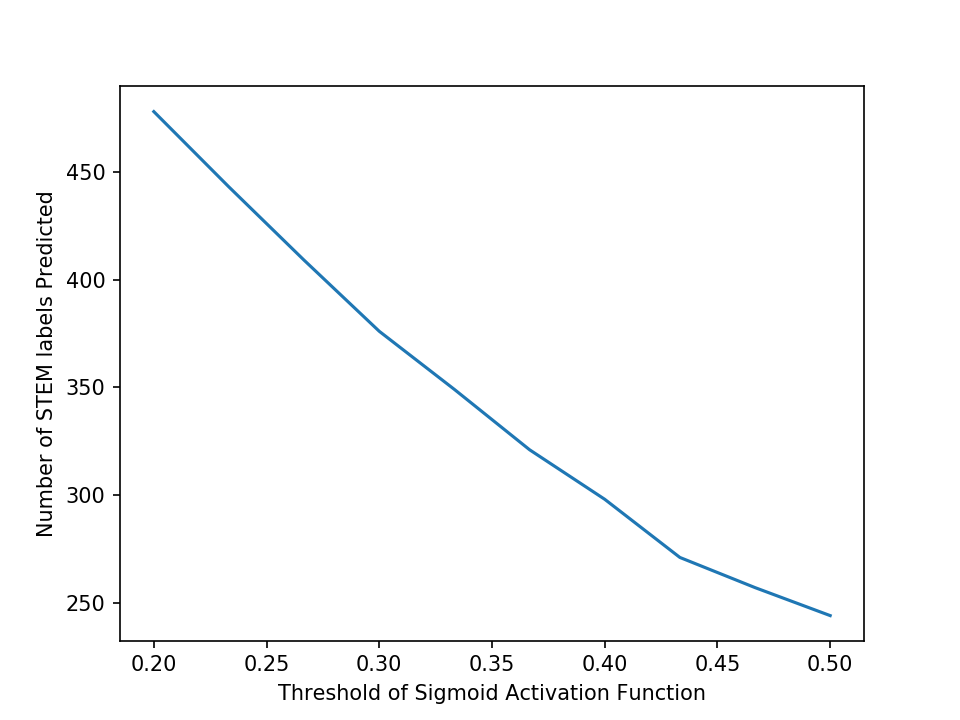

Text(0, 0.5, 'Number of STEM labels Predicted')

In [323]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib notebook
plt.plot(np.linspace(0.2, 0.5, 10), [result['pred_prob'].map(lambda x: x > y).sum() for y in np.linspace(0.2, 0.5, 10)])
plt.xlabel('Threshold of Sigmoid Activation Function')
plt.ylabel('Number of STEM labels Predicted')

In [266]:
result.loc[:, 'pred_low_threshold'] = result['pred_prob'].map(lambda x: x > 0.43)

In [267]:
result.to_csv('clf_result.csv')

array([[0.64253898, 0.02115813],
       [0.0545657 , 0.28173719]])

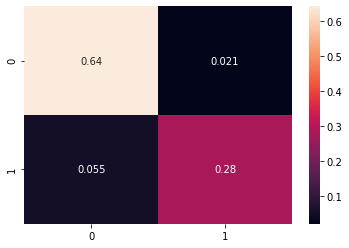

In [268]:
import seaborn as sns
conf_mat = confusion_matrix(result['SOC Official STEM'], result['pred_low_threshold'], normalize='all')
sns.heatmap(conf_mat, annot=True)
conf_mat

<IPython.core.display.Javascript object>


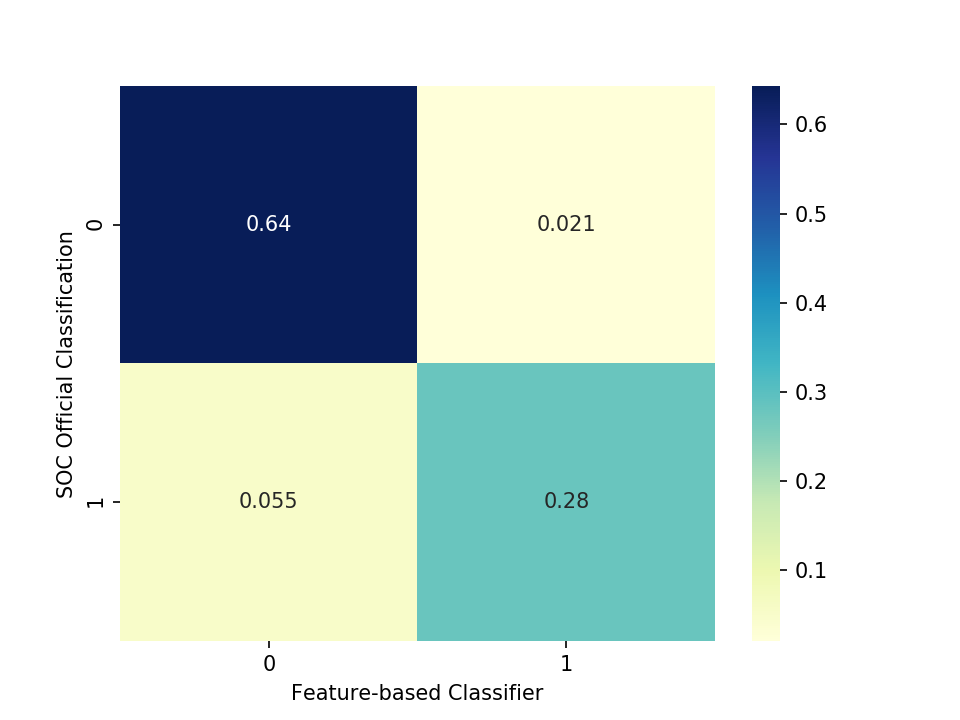

[Text(50.722222222222214, 0.5, 'SOC Official Classification'),
 Text(0.5, 23.52222222222222, 'Feature-based Classifier')]

In [319]:
ax = sns.heatmap(conf_mat, annot=True, cmap='YlGnBu')
ax.set(xlabel='Feature-based Classifier', ylabel='SOC Official Classification')